In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from hurst import compute_Hc, random_walk
import numba as nb

from alive_progress import alive_bar  

In [13]:
SECONDS_PER_YEAR = 365 * 24 * 60 * 60

index_dict = {
    'VolCrash400' : {'vol' : 0.2,
                'decay' : SECONDS_PER_YEAR / 400,
                'q' : 0,
                'eta_p' : 0,
                'eta_n' : 0.20/100,
                },
    'VolCrash550' : {'vol' : 0.2,
                'decay' : SECONDS_PER_YEAR / 550,
                'q' : 0,
                'eta_p' : 0,
                'eta_n' : 0.20/100,
                },
    'VolCrash750' : {'vol' : 0.2,
                'decay' : SECONDS_PER_YEAR / 750,
                'q' : 0,
                'eta_p' : 0,
                'eta_n' : 0.20/100,
                },
    'VolBoom400' : {'vol' : 0.2,
                'decay' : SECONDS_PER_YEAR / 400,
                'q' : 1,
                'eta_p' : 0.20/100,
                'eta_n' : 0,
                'vol' : 0.2,
                },
    'VolBoom550' : {'vol' : 0.2,
                'decay' : SECONDS_PER_YEAR / 550,
                'q' : 1,
                'eta_p' : 0.20/100,
                'eta_n' : 0,
                },
    'VolBoom750' : {'vol' : 0.2,
                'decay' : SECONDS_PER_YEAR / 750,
                'q' : 1,
                'eta_p' : 0.20/100,
                'eta_n' : 0,
                }
}

In [14]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

@nb.njit(fastmath=True)
def mgf_jump(q,eta_p,eta_n,t=0):
    return q/(1-t*eta_p)+(1-q)/(1+t*eta_n)

@nb.njit(fastmath=True)
def inv_J_cdf_mv(cdf,q,eta_p,eta_n):
    if cdf<1-q:
        return eta_n*np.log(cdf/(1-q))
    else:
        return-eta_p*np.log((1-cdf)/(q))

@nb.njit(fastmath=True)
def DEX_log_returns(eta_p, eta_n, decay, vol, q, n=1000000):
    dt = 1/365/86400
    mu = 0
    a=mgf_jump(q,eta_p,eta_n,t=1)-1
    
    W = np.zeros(n)
    N = np.zeros(n)
    jumps = np.zeros(n)

    # print('jump drift correction (-lambda * alpha * dt):', -(decay*a)*dt, f'vol drift correction (- vol^2/2 * dt):', - vol**2 / 2 * dt)

    for i in nb.prange(n):
        W[i] = np.random.normal()
        N[i] = np.random.poisson(decay * dt)
    
    for i in range(n):
        jump = 0
        for _ in range(N[i]):
            jump += inv_J_cdf_mv(np.random.uniform(),q,eta_p,eta_n)
        jumps[i] = jump

    log_S = np.zeros(n+1)
    
    for i in nb.prange(n):
        log_S[i+1] = (mu-vol**2/2-decay*a)*dt + vol*np.sqrt(dt) * W[i] + jumps[i]

    
    return log_S 

def DEX_sim(index, n=1000000, seed=None):
    S0 = 100
    if seed is not None:
        np.random.seed(seed)
    params = index_dict[index]
    log_S = DEX_log_returns(**params, n=n)
    return S0 * np.exp(np.cumsum(log_S))

In [15]:
VolCrash_indices = list(index_dict.keys())[:3]

variation1 = {
    'VolCrash400' : {'t_exclude' : 400,
                'interval' : 400,
                'jump_size' : -0.20/100,
                },
    'VolCrash550' : {'t_exclude' : 550,
                'interval' : 550,
                'jump_size' : -0.20/100,
                },
    'VolCrash750' : {'t_exclude' : 750,
                'interval' : 750,
                'jump_size' : -0.20/100,
                },
}

variation2 = {
    'VolCrash400' : {'t_exclude' : 400,
                'interval' : 5 * 60,
                'jump_size' : -0.20/100,
                },
    'VolCrash550' : {'t_exclude' : 550,
                'interval' : 5 * 60,
                'jump_size' : -0.20/100,
                },
    'VolCrash750' : {'t_exclude' : 750,
                'interval' : 5 * 60,
                'jump_size' : -0.20/100,
                },
}

variation3 = {
    'VolCrash400' : {'t_exclude' : 2 * 400,
                'interval' : 5 * 60,
                'jump_size' : -0.20/100,
                },
    'VolCrash550' : {'t_exclude' : 2 * 550,
                'interval' : 5 * 60,
                'jump_size' : -0.20/100,
                },
    'VolCrash750' : {'t_exclude' : 2 * 750,
                'interval' : 5 * 60,
                'jump_size' : -0.20/100,
                },
}


In [16]:
n = 86400*30*3
n_sim = 10_000

test_params = variation2
np.random.seed(0)
sim_result = []
for index in VolCrash_indices:
    print(index)

    t_exclude = test_params[index]['t_exclude']
    interval = test_params[index]['interval']
    jump_size = test_params[index]['jump_size']
    
    for _ in range(n_sim):
        S_mv=DEX_sim(index,n=n)
        rets = np.diff(S_mv, prepend=np.nan) / S_mv
        jumps = np.argwhere(rets < jump_size).flatten()
        result = []
        
        for i in range(len(jumps) - 2):
            if (jumps[i+1]-jumps[i]) < t_exclude:
                continue
            
            else:
                j = 1
                entry_time = jumps[i]+t_exclude
                while entry_time < jumps[i+1]:
                    entry_price = S_mv[entry_time]
                    avg_price = np.mean(S_mv[jumps[i]+t_exclude:jumps[i+1]])
                    exit_price = S_mv[jumps[i+1]]
                    result.append([entry_time,jumps[i+1],entry_price,avg_price,exit_price,entry_price-exit_price])
                    entry_time += interval
        # print(result)

        # # S_mv=DEX_sim(index,n=n)

        # test = pd.DataFrame(S_mv,columns=['mid'])
        # test['return'] = test.mid.pct_change()
        # test = test.reset_index()

        # jump = test[test['return']<jump_size].index
        # # display(jump, jumps)
        # # display(test['mid'].values == mids)
        # # display(test['return'][jump], rets[jumps])

        # result = []
        # for i in range(len(jump)-1):
        #     if (jump[i+1]-jump[i]) < t_exclude:
        #         continue
        #     else:
        #         entry_time = jump[i]+t_exclude
        #         while entry_time < jump[i+1]:

        #             entry_price = test['mid'].iloc[entry_time]
        #             avg_price = np.mean(test['mid'].iloc[jump[i]+t_exclude:jump[i+1]])
        #             exit_price = test['mid'].iloc[jump[i+1]]
        #             result.append([entry_time,jump[i+1],entry_price,avg_price,exit_price,entry_price-exit_price])
        #             entry_time += interval
        # print(result)

        tep = pd.DataFrame(result)
        tep.columns = ['entry','exit','ent_spot','avg_spot','ext_spot','pl']
        tep['hold_time'] = (tep.exit - tep.entry)
        tep['return'] =tep.pl/tep.ent_spot

        gb_exit = tep.groupby("exit").agg({'pl':'sum'})
        win_rate = len(gb_exit[gb_exit.pl>0])/len(gb_exit)
        hit_ratio = np.sum(np.where(gb_exit.pl>0,gb_exit.pl,0))/np.sum(np.where(gb_exit.pl>0,gb_exit.pl,-gb_exit.pl))

        sim_result.append([index,i,tep.pl.sum(),len(tep),hit_ratio,win_rate,tep.pl.mean(),tep.pl.median(),tep['return'].mean(),tep['return'].median()])

strategy_result = pd.DataFrame(sim_result)
strategy_result.columns = ['index','sim','Total PL','Total Trades','Hit Ratio','Win Rate','Mean PL','Median PL','Mean Return','Median Return']

VolCrash400
VolCrash550


In [ ]:
# mids = S_mv[:-1]
        # rets = np.diff(S_mv) / mids
        # jumps = np.argwhere(rets < jump_size).flatten()
        
        
        # for i in range(len(jumps) - 1):
        #     if (jumps[i+1]-jumps[i]) < t_exclude:
        #         continue
            
        #     else:
        #         j = 1
        #         entry_time = jumps[i]+t_exclude
        #         while entry_time < jumps[i+1]:
        #             entry_price = mids[entry_time]
        #             avg_price = np.mean(mids[jumps[i]+t_exclude:jumps[i+1]])
        #             exit_price = mids[jumps[i+1]]
        #             result.append([entry_time,jumps[i+1],entry_price,avg_price,exit_price,entry_price-exit_price])
        #             entry_time += interval
        #             j+=1
        # display(mids)
        # display(rets)
        # display(jumps)

In [10]:
strategy_result.to_csv('./strategy_results_VolCrash_Variation1.csv')

In [6]:
strategy_result = pd.read_csv("/Users/kuanlim/Documents/24. DEX Validation/strategy_result.csv")
# strategy_result.columns = ['index','sim','Total PL','Total Trades','Hit Ratio','Win Rate','Mean PL','Median PL','Mean Return','Median Return']

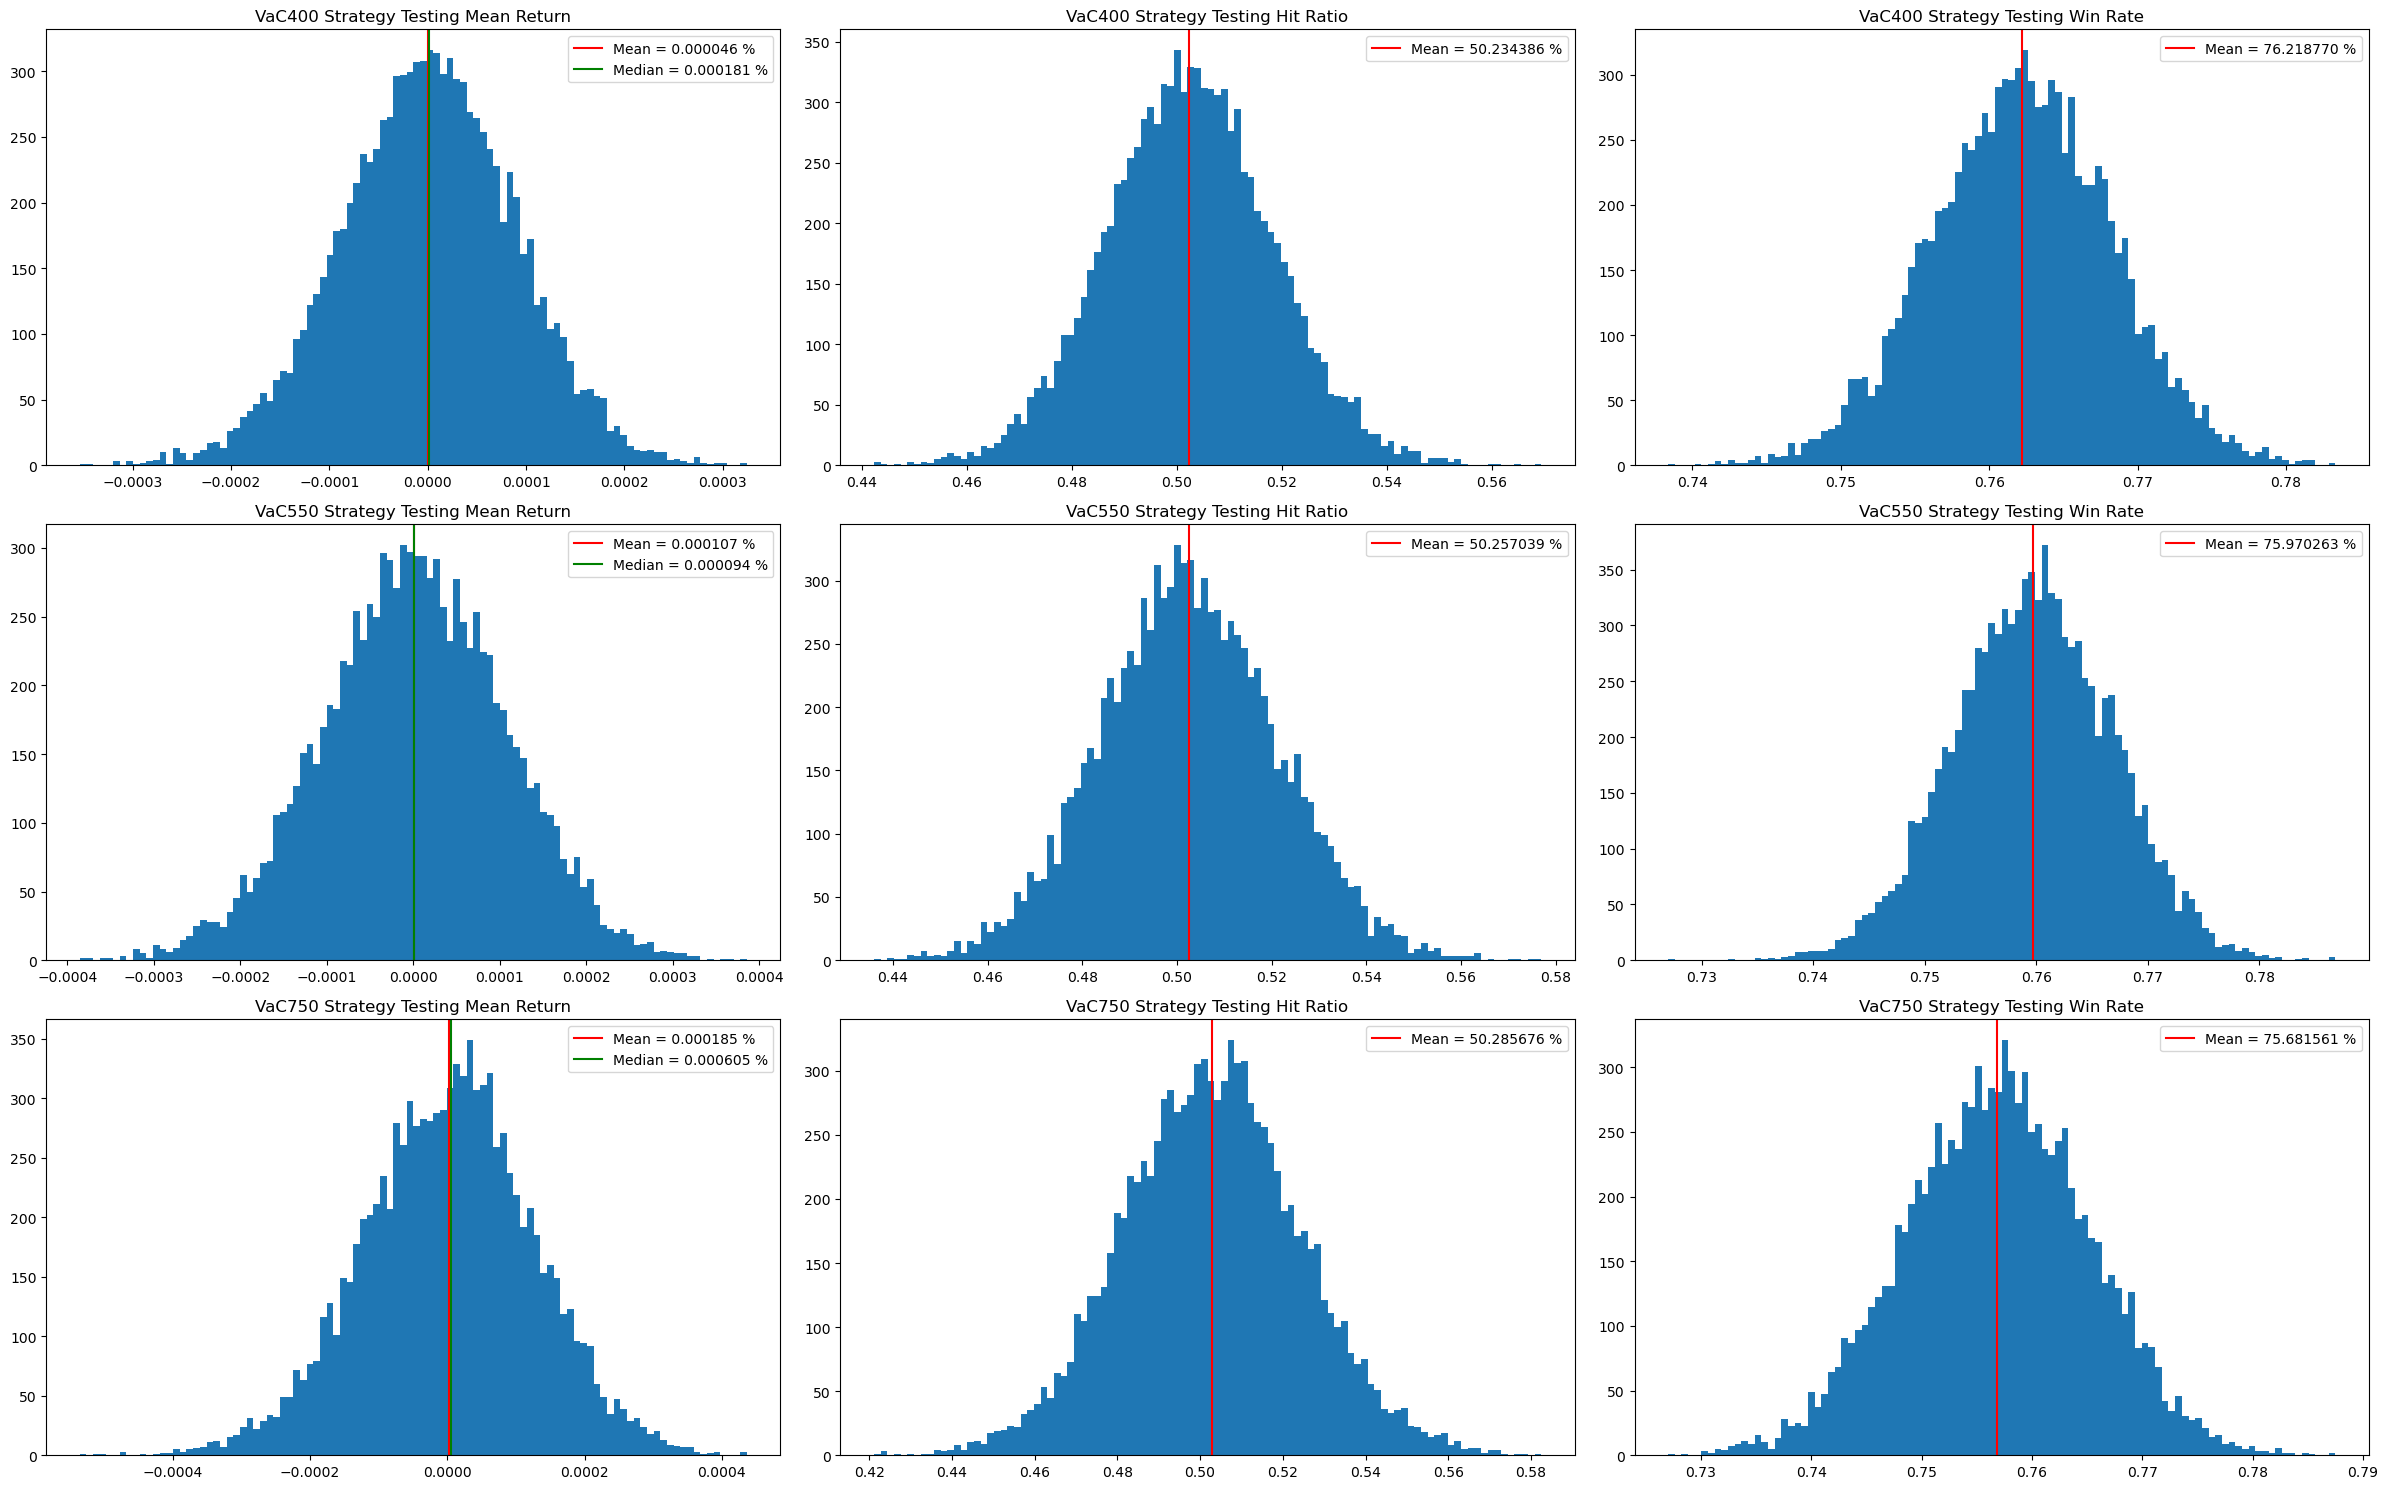

In [9]:
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(24,15))
i=0

for index in VolCrash_indices:

    # Mean Return
    df_plot = strategy_result[strategy_result['index']==index]['Mean Return']
    ax[i,0].hist(df_plot,bins=100)
    ax[i,0].set_title(f"{index} Strategy Testing Mean Return")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,0].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,0].axvline(median_return,color='green',label = f"Median = {median_return*100:.6f} %")
    ax[i,0].legend()

    # Hit Ratio
    df_plot = strategy_result[strategy_result['index']==index]['Hit Ratio']
    ax[i,1].hist(df_plot,bins=100)
    ax[i,1].set_title(f"{index} Strategy Testing Hit Ratio")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,1].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,1].legend()

    # Win Rate 
    df_plot = strategy_result[strategy_result['index']==index]['Win Rate']
    ax[i,2].hist(df_plot,bins=100)
    ax[i,2].set_title(f"{index} Strategy Testing Win Rate")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,2].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,2].legend()
    

    
    i+=1

plt.tight_layout()

plt.show()